In [85]:
# @CX-REMOVE
import ipynbname
nb_name = ipynbname.path().name

In [86]:
%%script bash -s $nb_name
# @CX-REMOVE
#
# Export Notebook as Blogpost
#
./render.sh ./$1 ./nb.html
cat <<EOF > fm.html
---
title: Solar Plant Investment
date: 2023-08-12
url: /solar
outputs:
  - RawHTML
---
EOF

cat fm.html nb.html \
    > /host/root/home/hhartmann/src/HeinrichHartmann.github.io/hugo/content/posts/raw/solar.html

[NbConvertApp] Converting notebook ./SolarPlant.ipynb to HTML
[NbConvertApp] Writing 1403358 bytes to nb.html


# The Solar Plant Investment

In this note, we are going to explore the economic value of investments, in the example of a Solar Plant, aka. Photovoltaic (PV) System:

- 20,000 EUR are the costs of the system.
- 1,250 EUR are the annual returns in reductions to my power bill, and gains from selling electricity. 
- 30 years, is the expected lifetime the system.

**Question: Is this system worth buying?**

Theare are multiple paramteres to consider:

1. Equity (10,000 EUR) -- The amount of money I have available right now to invest into this system.
2. Credit Costs -- Right now credits are rather expensive, with >6% interest for 10 year credit lines.
3. Inflation (6%) -- Currently we are at a record high inflation of 6.7% in Germany. Long term median is around 2%.
3. Opportunity Costs -- If equity is invested, we can't invest it somewhere else.

We will use this tasks to develop a general investment evaluation framework, that is very much overkill for the task,
and then apply it to the case in point.

**Meta:** This note is written inside a Jupyter notbook, which is available here: ...

In [10]:
# USE THE SOURCE, LUKE!
# @CX-TOGGLE @CX-NO-OUTPUT
#
# Dependencies
#
# (Uncomment and execute once)
#!pip install numpy-financial ipytest pandas numpy matplotlib

#
# Imports
#
from dataclasses import dataclass

import numpy as np
import numpy_financial as npf
import pandas as pd

from scipy.optimize import minimize, minimize_scalar
from matplotlib import pyplot as plt
plt.rcParams["figure.figsize"] = (20,5)

import ipytest
import pytest
ipytest.autoconfig()

#
# Helper
#
def P_EUR(num):
    print(f"{num:,.0f} EUR")
    
def P(num, unit):
    print(f"{num:,.1f} {unit}")
    
def p(text):
    print(text, end='')


#
# Classes
#
class CashFlow(pd.Series):
   
    @classmethod
    def from_constant(cls, years, value):
        return cls(np.zeros(years + 1) + value)

    @classmethod
    def from_investment(cls, N, PV, PMT):
        cf = np.zeros(N + 1)
        cf[0] = -PV
        cf[1:] += PMT
        return cls(cf, name="Cash Flow")
    
    def pad(self, years):
        return CashFlow(self.copy().reindex(range(years+1), fill_value = 0))

    def plot(self, **kwargs):
        if not "kind" in kwargs:
            kwargs["kind"] = "bar"
        super().plot(**kwargs)
        plt.title("Cash Flow Plot")
        plt.ylabel("Cash Flow/EUR")
        plt.xlabel("Year")
        plt.axhline(y=0, color='k', linewidth=0.5)

    def discount(self, interest_rate):
        discount_factor = 1 / (1 + interest_rate) ** np.arange(len(self))
        return CashFlow( self * discount_factor )

    def present_value(self, interest_rate):
        return npf.npv(interest_rate, self)
    
    def neg(self):
        o = self.copy()
        o[ o > 0 ] = 0
        return CashFlow(o)
    
    def pos(self):
        o = self.copy()
        o[ o < 0 ] = 0
        return CashFlow(o)
    
    def __add__(self, other):
        l = max(len(self), len(other))
        return CashFlow( np.array(self.pad(l)) + np.array(other.pad(l)) )

class ValueSeries(pd.Series):
    "Represents the value of an asset over time."
    
    @classmethod
    def from_deposit(cls, years, amount):
        return cls(np.zeros(years + 1) + amount, name="Value Series")
    
    @classmethod
    def from_cash_flow(cls, cf : CashFlow):
        return cls(np.cumsum(cf), name="Value Series")
    
    def with_interest(self, interest_rate):
        out = ValueSeries(self.copy())
        for i in range(1, len(out)):
            out[i:] += out[i-1] * interest_rate
        return out
        
    def discount(self, interest_rate):
        discount_factor = 1 / (1 + interest_rate) ** np.arange(len(self))
        return ValueSeries(self * discount_factor)
        
    def cash_flow(self):
        return CashFlow(self.diff())
    
    def total(self):
        return self.iloc[-1]
    
    def plot(self, **kwargs):
        if not "kind" in kwargs:
            kwargs["kind"] = "bar"
        super().plot(**kwargs)
        plt.ylabel("EUR")
        plt.xlabel("Year")
        plt.axhline(y=0, color='k', linewidth=0.5)
        plt.ylabel("Accumulated Value")
        plt.title("Accumulated Value Plot")
        
    def __add__(self, other):
        return ValueSeries(np.array(self) + other)
    
    def __radd__(self, other):
        return ValueSeries(np.array(self) + other)
    

@dataclass
class Credit:
    amount : float
    years  : int
    interest : float

    def rate(self):
        return - npf.pmt(self.interest, self.years, self.amount)

    def cash_flow(self):
        cf = np.zeros(self.years + 1)
        cf[0] = self.amount
        cf[1:] = - self.rate()
        return CashFlow(cf)
    
    def costs(self):
        return self.rate() * self.years - self.amount
    
def new_credit(amount,years,interest):
    Credit(amount, years, interest)

In [24]:
%%ipytest
# @CX-REMOVE
def test_CashFlow():
    CF = CashFlow.from_investment(INV_LIFETIME, INV_COST, INV_ANNUAL_RETURN) 
    assert CF.discount(0.05).sum() == CF.present_value(0.05)
    assert CF.discount(0).sum() == CF.sum()
    assert CF.present_value(0) == CF.sum()
    
def test_cc():
    "We can compute the total sum of credit cash flow with credit_costs"
    cf = Credit(20000, 10, 0.05).cash_flow()
    assert cf.sum() == -Credit(20000, 10, 0.05).costs()

def test_discounted_cc():
    "Summing the discounted cash-flow gives close to zero value"
    cf = Credit(20000, 10, 0.05).cash_flow().discount(0.05)
    assert cf.sum() == pytest.approx(0, abs=1e-6)

...                                                                                          [100%]
3 passed in 0.02s


## Naive Profit

How much money does the investment make over the lifetime?

In [53]:
INV_COST = 20_000 # in EUR
INV_ANNUAL_RETURN = 1_250  # in EUR
INV_LIFETIME = 30 # in years

In [41]:
P_EUR( INV_ANNUAL_RETURN * INV_LIFETIME - INV_COST )

17,500 EUR


So after 30 years we will have returned our investment and additionaly gained 17,500 EUR.
On the surface it looks like this may be a good investment.

In [54]:
# Annualized Return

PROFIT = INV_ANNUAL_RETURN * INV_LIFETIME 

ROE_RATE = (PROFIT / INV_COST) ** (1/INV_LIFETIME) - 1

In [55]:
ROE_RATE

0.02117469047982179

In [56]:
INV_COST * (1 + ROE_RATE) ** INV_LIFETIME

37499.999999999956

## Opportunity Cost

If we invest all our money into a PV system, this means we can't put it somewhere else. We have missed an "opportunity". 

The most basic thing we can do with the 20K is to put it into a savings account with moderate interest of 2%.

In [23]:
# Investing the same money into a savings account with 2% interest.
P_EUR( INV_COST * (1+0.02) ** INV_LIFETIME )

36,227 EUR


So putting the 20K into a simple savings account, we are left with 36,227 EUR after 30 years.
This is about 20K more than we would have with the PV Investment.
At the stock market we could expect even grater returns.

From this perspective we should avoid buying a PV System.

## Credit Leverage

Assume that we could lend the lend the 20K for 0% interest over 20 years.
In this case would pay 1K per year to pay back the credit, which is less than the 1,250EUR we are gaining from the investment.

This means, that we are generating a profit of 250 EUR p.a. for the first 20 years, and then have a PV system which generates
further profit. From this perspective it's a clear win!

This is a clear win!

## Return on Equity

## Cash Flow Analysis

We are trading two different cash flows for each other, and want to know which one has a higher value for us right now.
We represent cash flows as arrays of numbers representing annual payments.

The cash flow generated by our investment looks as follows:

1. We have a negateive cash flow of 20,000 EUR in the first year
2. We have annual returns of +1250 EUR in the 30 following years

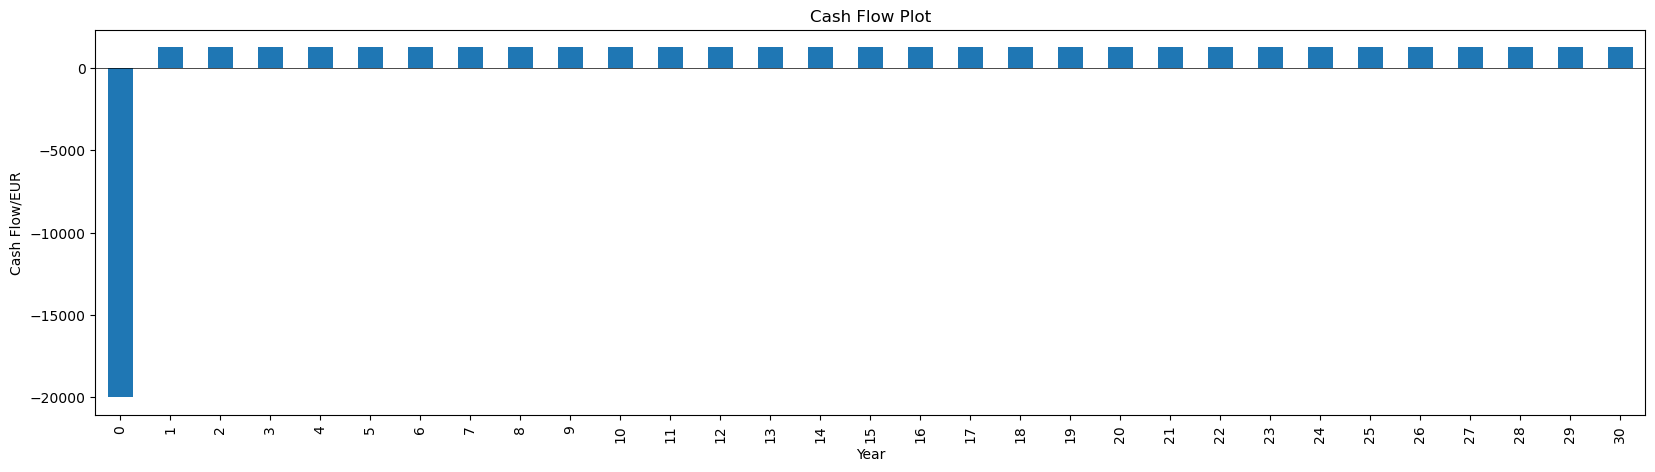

In [11]:
CF = CashFlow.from_investment(INV_LIFETIME, INV_COST, INV_ANNUAL_RETURN) 
CF.plot()

In [12]:
# The sum of all payments, gives back the naive profit:
P_EUR( CF.sum() )

17,500 EUR


### The effects of inflation: Discounting Cash Flows

The cash flow class let's us simulate the effects of inflation to cash flow.
Assuming a inflation rate of 2% the method .discount() translates future amounts into their present-day value.

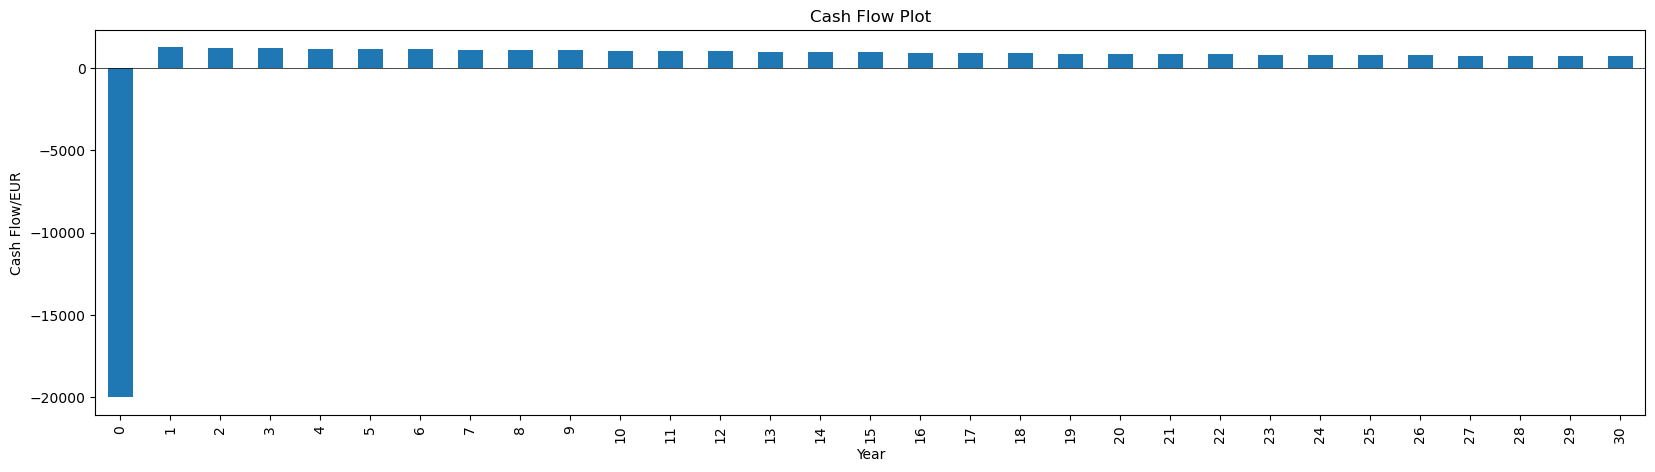

In [13]:
INFLATION = 0.02
CF.discount(INFLATION).plot()

The discounted value of the cash-flow is lower than the naive profit of 17.5K EUR:

In [14]:
P_EUR( CF.discount(INFLATION).sum() )

7,996 EUR


We call the sum of a discounted cash flow a **present value**.
The function CF.present_value(rate) is an abbreviation for CF.discount(rate).sum()

In [15]:
P_EUR( CF.present_value(INFLATION) )

7,996 EUR


### The effects or inflation to present values

In our example, we had a positive present value of ~17K at zero interest.
With 2% inflation we are at ~8K.
With higher interest rates the investment can get a negative present value:

In [16]:
P_EUR( CF.present_value(0.10) )

-8,216 EUR


For our case of a Photovoltaic System we are not directly generating cash as an investment return but electricity.
At the moment, in Germany we don't expect electricity prices to stay constant or shrink with inflation.
If electricity prices raise with 3% each year, we would get an effective inflation rate of -1% for the investment:

In [17]:
P_EUR( CF.present_value(-0.01) )

23,987 EUR


Let's explore the dependency of the inflation rate on the present value of the cash flow:

Limit discount rate = 4.653%


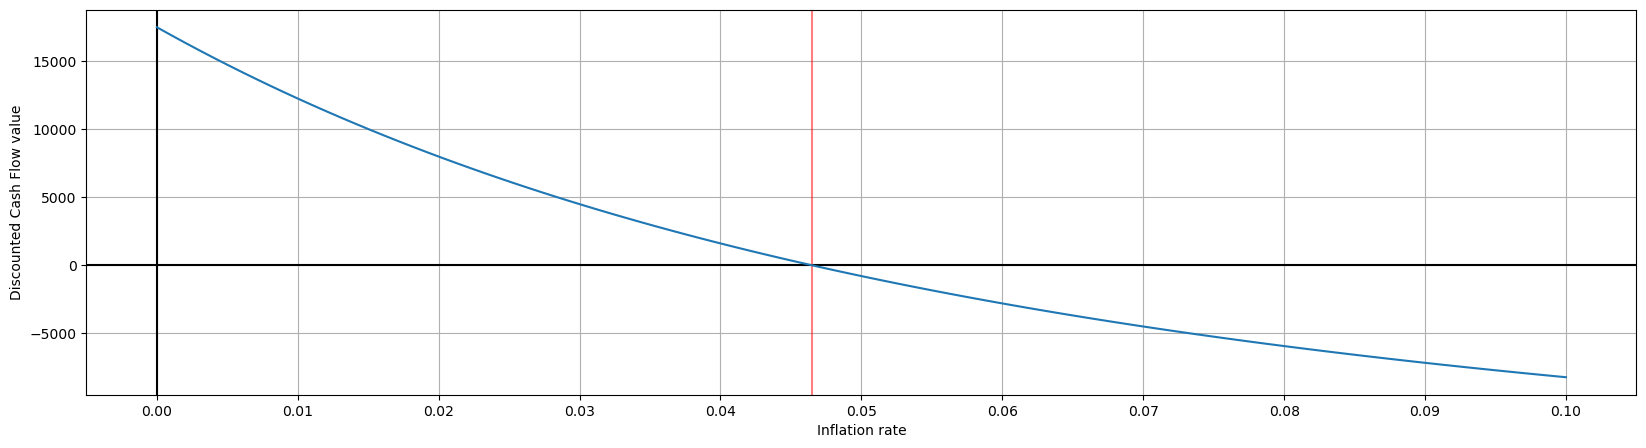

In [153]:
# Optimization & Plotting Logic ...
# @CX-TOGGLE
from scipy.optimize import root_scalar

def cash_flow_solve_discount_interest(cf):
    res = root_scalar(lambda x: cf.present_value(x), bracket=[0,1])
    if res.converged:
        return res.root
    else:
        raise None

r = cash_flow_solve_discount_interest(CF)
print(f"Limit discount rate = {r*100:.3f}%")
        
# Plot dependency
MAX_INTEREST = 0.1
plt.figure(figsize=(20,5))
X = np.linspace(0,MAX_INTEREST,100)
Y = [ CF.present_value(x) for x in X]
plt.xlabel("Inflation rate")
plt.ylabel("Discounted Cash Flow value")
plt.grid(True)
plt.xticks(np.linspace(0,MAX_INTEREST,11))
plt.axhline(y=0, color='k')
plt.axvline(x=0, color='k')
plt.axvline(x=r, color='r', alpha=0.5)
plt.plot(X, Y);

We see that the investment is decreasing in present value with growing inflation.
At 4.6% interest the investment has a present value of exactly zero.

## Modeling Opportunity Costs

The alterntaive to investing the money, we can put it into a savings account.
We choose to model bank accounts with a ValueSeries object defined below.

In [50]:
%%ipytest
# @CX-REMOVE
def test_reverse():
    # Discounting reverses the effect
    AV = ValueSeries.from_deposit(INV_LIFETIME, INV_COST).with_interest(0.05).discount(0.05)
    assert ((AV - ValueSeries.from_deposit(INV_LIFETIME, INV_COST)).abs() < 1e-6).all()

.                                                                                            [100%]
1 passed in 0.02s


Let's model our savings account (AC) with a ValueSeries:

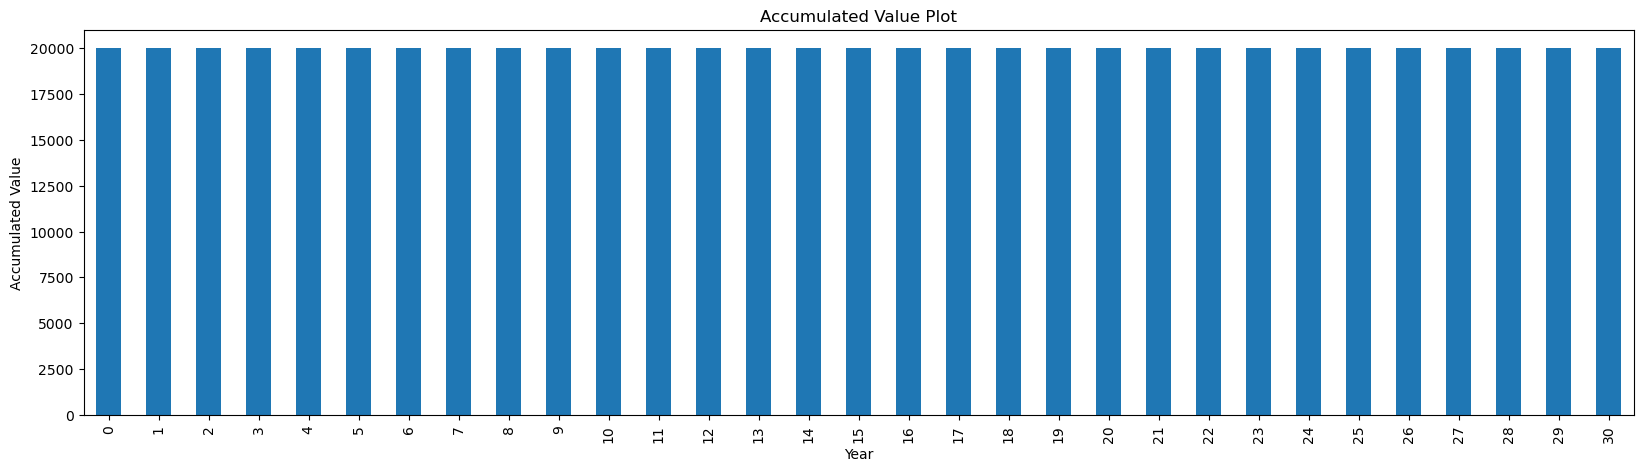

In [51]:
AC = ValueSeries.from_deposit(INV_LIFETIME, 20000)
AC.plot()

To get a more realistic model, we need to take into account the effects of inflation and interest.

With an (optimistic) interest rate of 5%, we are at a whopping 86K after 30 years!

86,439 EUR


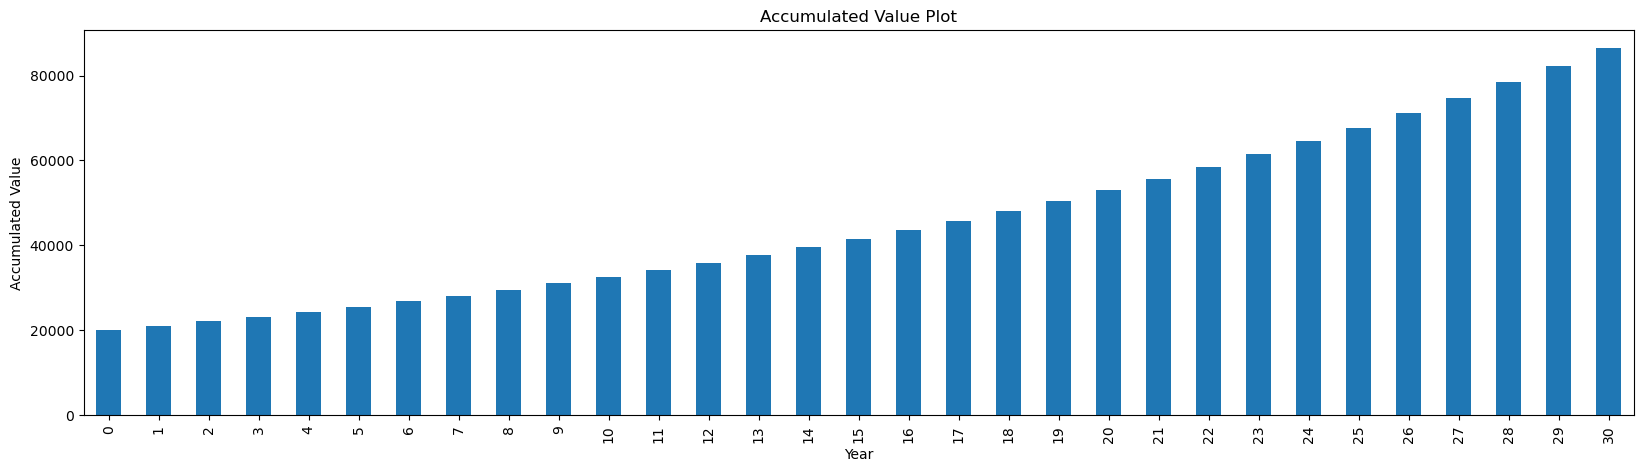

In [52]:
AC.with_interest(0.05).plot()
P_EUR( AC.with_interest(0.05).total() )

Discounting for inflation, we get a "present value" of ~50K for the savings account:

In [53]:
P_EUR( AC.with_interest(0.05).discount(INFLATION).total() )

47,720 EUR


## Investment Calculator #1: <br> Investment Value vs. Opportunity Value

With models for Investment Value and Opportunity Costs available, we are ready for our first analysis.

Assuming we have 20K equity available, we compare:

* Option A (Investment): Spend all the equity on a PV system.
* Option B (Opportunity): Invest the equity into the stock market.

The following code-cell contains all the parameters that go into the calculation.

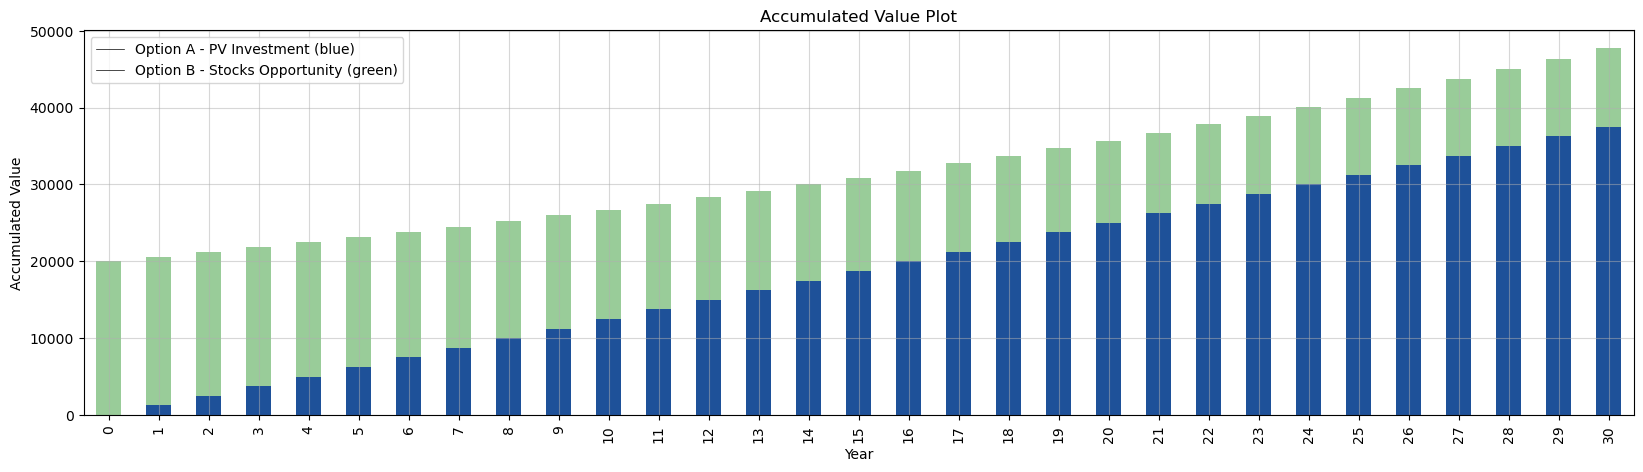

Investement Value: 37,500 EUR
Opportunity Value: 47,720 EUR
Delta:             -10,220 EUR


In [155]:
INV_COST = 20_000 # in EUR
INV_ANNUAL_RETURN = 1_250  # in EUR
INV_LIFETIME = 30 # in years
INV_INFLATION = 0.00 # inflation for the investment returns

EQUITY = 20_000 # in EUR
EQ_INFLATION = 0.02
EQ_INTEREST = 0.05
# @CX-TOGGLE
# Option A
CF_A = CashFlow.from_investment(INV_LIFETIME, INV_COST, INV_ANNUAL_RETURN)\
       .discount(INV_INFLATION)
AV_A = (EQUITY + ValueSeries.from_cash_flow(CF_A))

# Option B
AV_B = ValueSeries.from_deposit(INV_LIFETIME, EQUITY)\
       .with_interest(EQ_INTEREST)\
       .discount(EQ_INFLATION)

AV_A.plot(color="blue", alpha=0.8)
AV_B.plot(color="green", alpha=0.4)
plt.grid(True, alpha=0.5)
plt.legend(["Option A - PV Investment (blue)", "Option B - Stocks Opportunity (green)"]);
plt.show()

print("Investement Value: ", end='')
P_EUR( AV_A.total() )
print("Opportunity Value: ", end='')
P_EUR( AV_B.total() )
print("Delta:             ", end='')
P_EUR( AV_A.total() - AV_B.total() )

### Findings

Based on the analysis above, the investment is not worth making.
We are 10K better of (in today's EUR) by investing our equity into stocks, than buying the PV system.

## Credit Leverage

Investments, that are not worth making with owned equity, can be profitable if we are lending money.
Assume in an extreme example, we could lend the 20K for 0% interest over 20 years.
In this case would pay 1K per year to pay back the credit, which is less than the 1,250EUR we are gaining from the investment.

This is a clear win!

Let's model this calculation.

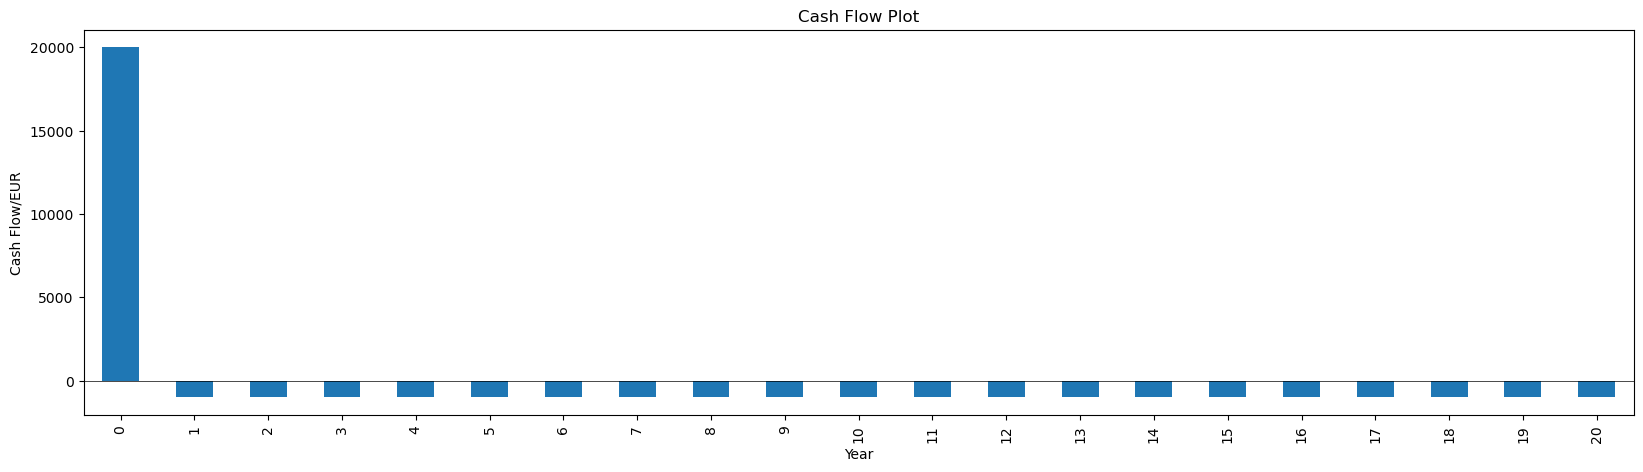

In [158]:
# This is the cash flow generated from the 20 year credit with zero
CCF = Credit(amount = 20000, years = 20, interest = 0.00).cash_flow()
CCF.plot()

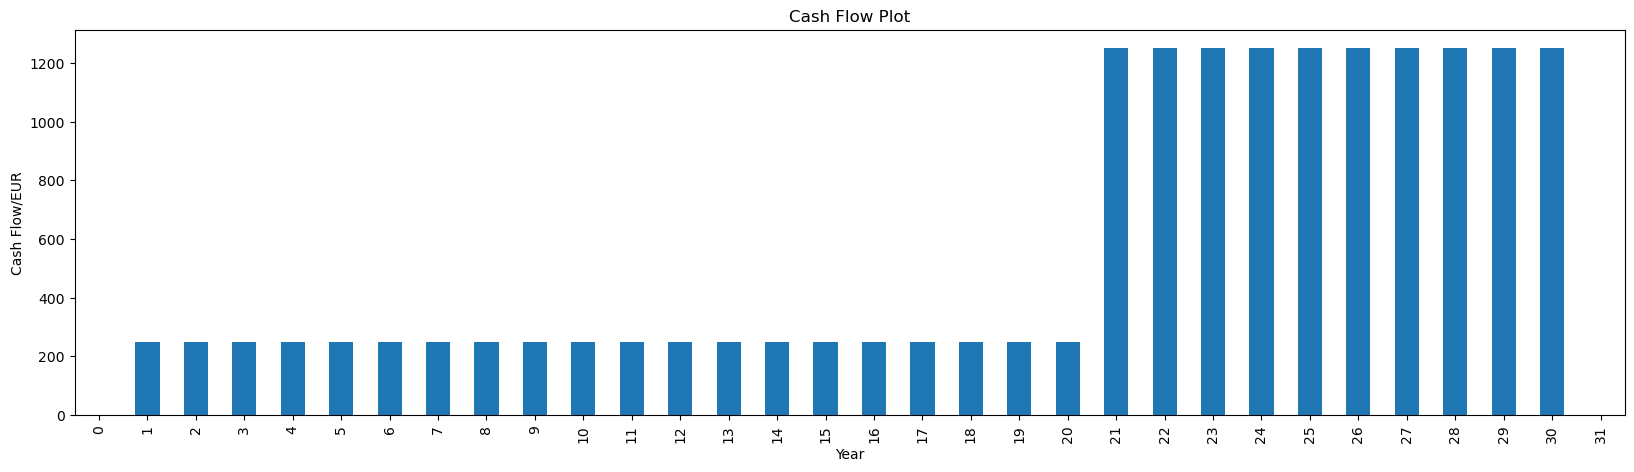

17,500 EUR


In [159]:
# Adding the Credit Cash flow to the Investment Cash Flow from above:
(CF+CCF).plot();
plt.show()
P_EUR( (CF+CCF).present_value(0) )

The present value of the cash flow stays at around ~17.5K, but the important difference is that **we don't need to invest our equity to pay this investment.**
We can still invest the 20K into the stock market and get additional returns.


## Investment Calculator #2: <br> Naive Credit Cash Flow Calculator

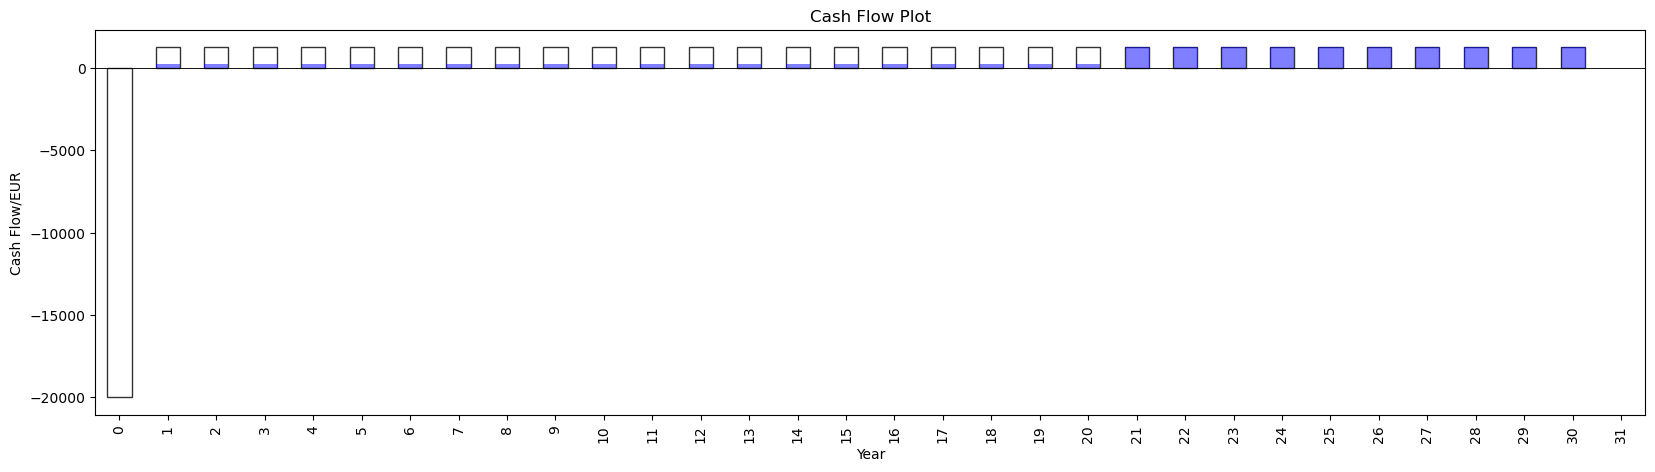

Present value of original cash flow    : 17,500 EUR
Present value of cash flow after credit: 17,500 EUR


In [227]:
INV_COST = 20_000 # in EUR
INV_ANNUAL_RETURN = 1_250  # in EUR
INV_LIFETIME = 30 # in years

CREDIT_AMOUNT = 20_000
CREDIT_YEARS = 20
CREDIT_INTEREST = 0.00
# @CX-TOGGLE

CF = CashFlow.from_investment(INV_LIFETIME, INV_COST, INV_ANNUAL_RETURN)
ccf = Credit(CREDIT_AMOUNT, CREDIT_YEARS, CREDIT_INTEREST).cash_flow()
tcf = CF + ccf

CF.plot(
    alpha=0.8,
    color = 'white',
    edgecolor = 'k'
)
tcf.plot(
    alpha = 0.5,
    color = 'b'
)
plt.show();
print("Present value of original cash flow    : ", end='')
P_EUR( CF.present_value(0.0) )
print("Present value of cash flow after credit: ", end='')
P_EUR( tcf.present_value(0.0) )

### Return on Equity

The key question for evaluating leveraged investment opportunities, is how much we gain relative to how much of our free equity we invest.

    ROE = (Present Value of Cash Flow) / (Total Equity)

Here "total equity" has two components:

1. Initial equity we have upfront
2. Equity we invest in future years

In the above example, we did not have to invest any of our own equity, making the ROE infinite.
In a more realistic eample, we are getting a ROE < 1:

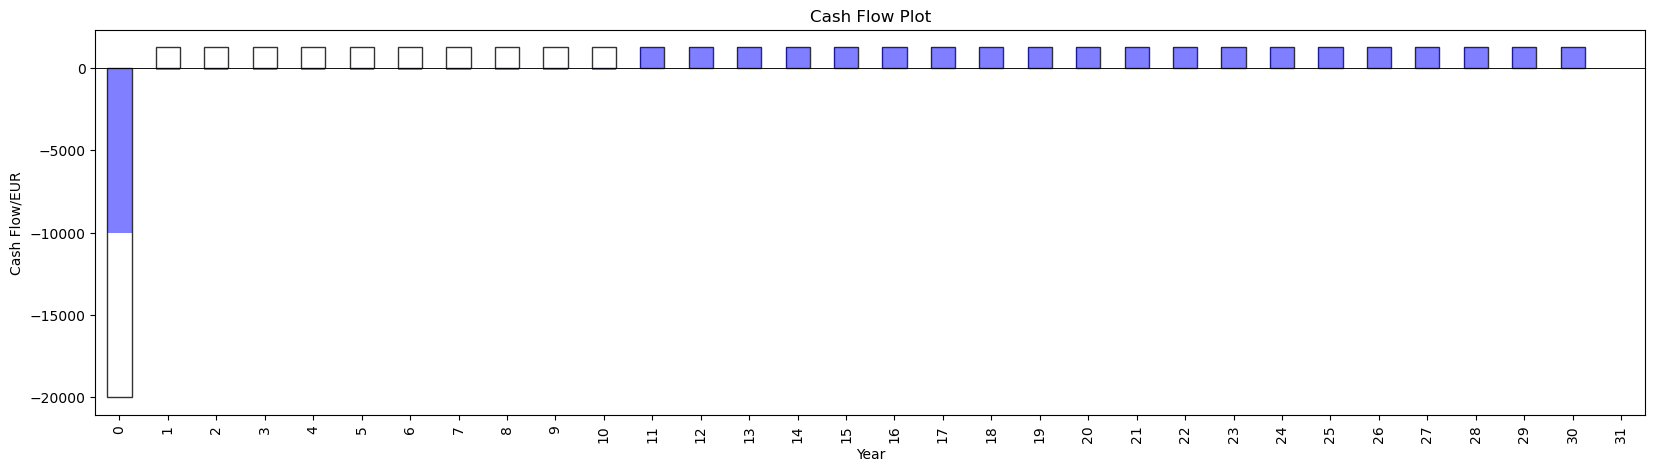

Total Equity:               11,087 EUR
Present Value of Cash Flow: 13,913 EUR
ROE:                        1.255


In [287]:
CREDIT_AMOUNT = 10_000
CREDIT_YEARS = 10
CREDIT_INTEREST = 0.06
# @CX-TOGGLE
cf = CashFlow.from_investment(INV_LIFETIME, INV_COST, INV_ANNUAL_RETURN)
ccf = Credit(CREDIT_AMOUNT, CREDIT_YEARS, CREDIT_INTEREST).cash_flow()
tcf = cf + ccf
cf.plot(
    alpha=0.8,
    color = 'white',
    edgecolor = 'k'
)
tcf.plot(
    alpha = 0.5,
    color = 'b'
)
plt.show();
t_equity = -tcf.neg().present_value(0)
pv = tcf.present_value(0)
p("Total Equity:               "); P_EUR( t_equity )
p("Present Value of Cash Flow: "); P_EUR( pv )
p("ROE:                        "); print(f"{pv / t_equity:.3f}")

## Optimizing ROE

If we have a given budget at our disposal, we can choose to invest a part of it into the PV system and finance the rest with a credit.
But, which fraction do we have to invest in order to maximize the ROE?


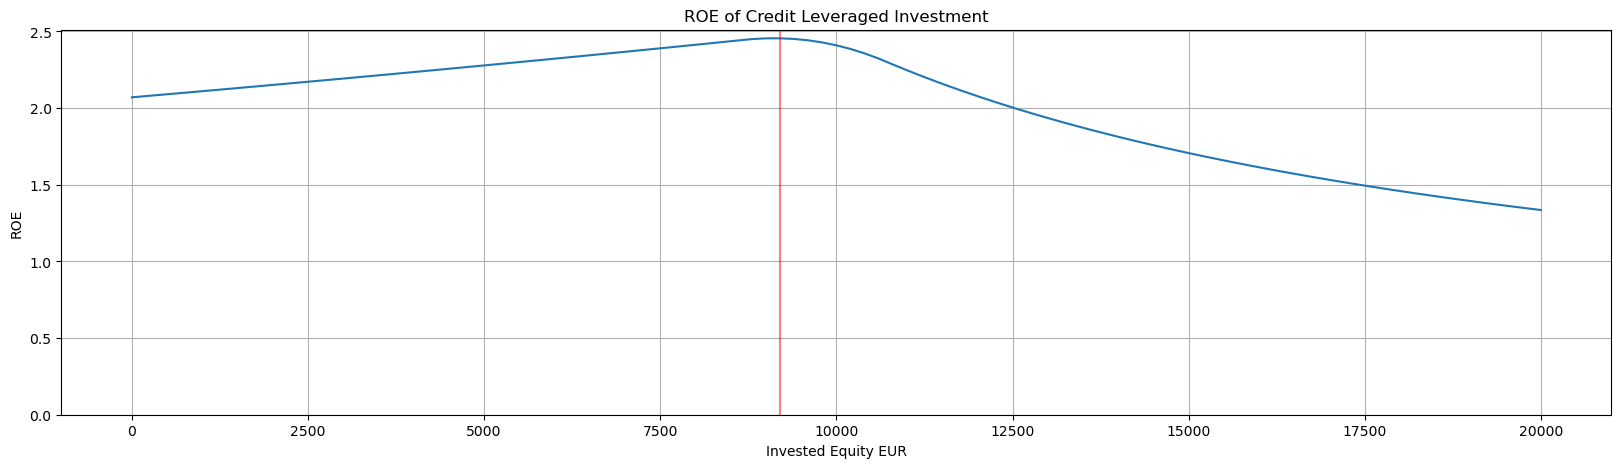

Optimal Investment is: 9,200 EUR
Maximal ROE:           2.455


In [324]:
# ROI Analysis for a more realistic investment scenario ...
INV_COST = 20_000
INV_ANNUAL_RETURN = 1_250
INV_LIFETIME = 30

CREDIT_YEARS = 10
CREDIT_INTEREST = 0.06
EQ_INFLATION = 0.02
# @CX-TOGGLE

def roi(equity):
    CREDIT_AMOUNT = INV_COST - equity
    years = max(INV_LIFETIME, CREDIT_YEARS)
    CF_A = CashFlow.from_investment(INV_LIFETIME, INV_COST, INV_ANNUAL_RETURN)\
           .discount(INV_INFLATION).pad(years)
    CCF_A = Credit(CREDIT_AMOUNT, CREDIT_YEARS, CREDIT_INTEREST).cash_flow()\
           .discount(EQ_INFLATION).pad(years)
    AV_A = (EQUITY + ValueSeries.from_cash_flow(CF_A) + ValueSeries.from_cash_flow(CCF_A))    
    t_equity  = - (CF_A + CCF_A).neg().present_value(EQ_INFLATION)
    return AV_A.total()/t_equity

X = np.linspace(0, INV_COST,101)
Y = [ roi(x) for x in X]
plt.plot(X,Y)
plt.axvline(x=X[x], color='r', alpha=0.5)
plt.ylabel("ROE")
plt.xlabel("Invested Equity EUR")
plt.title("ROE of Credit Leveraged Investment")
plt.grid(True)
plt.ylim(0)
plt.show()

x = np.argmax(Y);
p("Optimal Investment is: "); P_EUR(X[x])
p("Maximal ROE:           "); print(f"{Y[x]:.3f}")

## Investment Calculator<br>Credit Leveraged Investments vs. Opportunity Costs

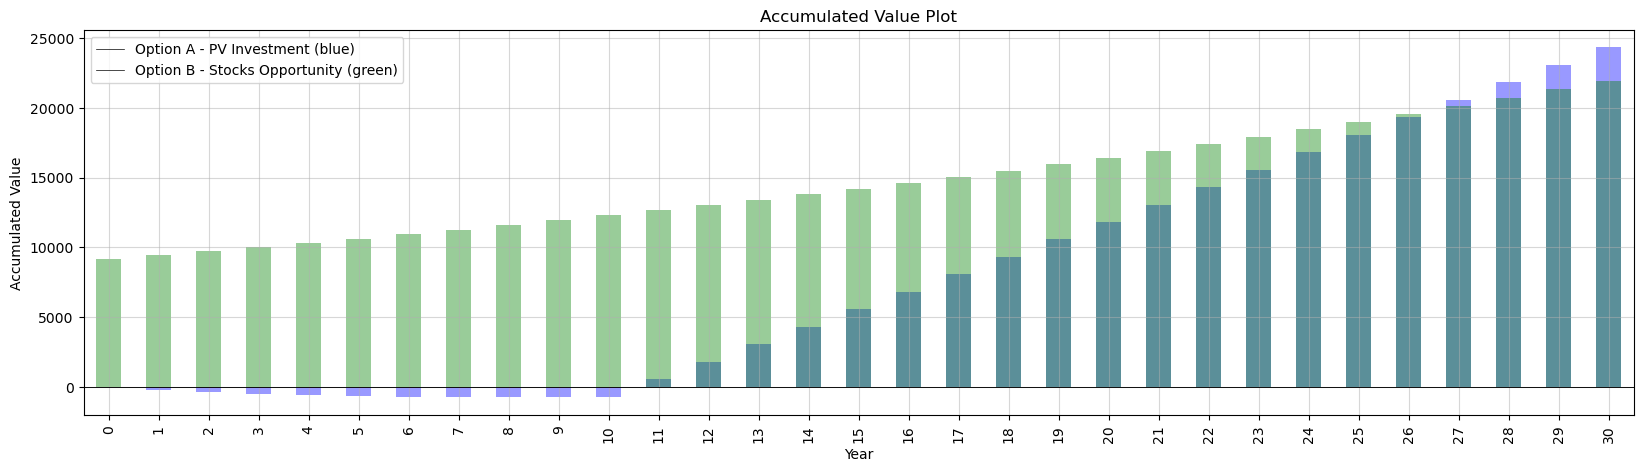

Investement Value:           24,319 EUR
- Total Equity need:         9,906 EUR
- ROE:                       2.455

Opportunity Value:           21,951 EUR
- Total Equity need:         9,200 EUR
- ROE:                       2.386


In [325]:
EQUITY = 9_200

INV_COST = 20_000
INV_ANNUAL_RETURN = 1_250
INV_LIFETIME = 30
INV_INFLATION = 0.00

CREDIT_AMOUNT = INV_COST - EQUITY
CREDIT_YEARS = 10
CREDIT_INTEREST = 0.06

EQ_INFLATION = 0.02
EQ_INTEREST = 0.05
# @CX-TOGGLE
# Option A
years = max(INV_LIFETIME, CREDIT_YEARS)
CF_A = CashFlow.from_investment(INV_LIFETIME, INV_COST, INV_ANNUAL_RETURN)\
       .discount(INV_INFLATION).pad(years)
CCF_A = Credit(CREDIT_AMOUNT, CREDIT_YEARS, CREDIT_INTEREST).cash_flow()\
       .discount(EQ_INFLATION).pad(years)
AV_A = (EQUITY + ValueSeries.from_cash_flow(CF_A) + ValueSeries.from_cash_flow(CCF_A))


# Option B
AV_B = ValueSeries.from_deposit(INV_LIFETIME, EQUITY)\
       .with_interest(EQ_INTEREST)\
       .discount(EQ_INFLATION)

AV_A.plot(color="blue", alpha=0.4)
AV_B.plot(color="green", alpha=0.4)
plt.grid(True, alpha=0.5)
plt.legend(["Option A - PV Investment (blue)", "Option B - Stocks Opportunity (green)"]);
plt.show()

tcf = (CF_A + CCF_A)
t_equity = -tcf.neg().present_value(EQ_INFLATION)
pv = AV_A.total()


p("Investement Value:           "); P_EUR( AV_A.total() )
p("- Total Equity need:         "); P_EUR( t_equity )
p("- ROE:                       "); print(f"{pv / t_equity:.3f}")
print()
p("Opportunity Value:           "); P_EUR( AV_B.total() )
p("- Total Equity need:         "); P_EUR( EQUITY )
p("- ROE:                       "); print(f"{AV_B.total() / EQUITY:.3f}")

## Findings

We optimize our ROI by investing 9,206K directly into a PV system, and financing the remaining 11K with a credit.
We almost exactly balance out the credit costs with the investment gains, and only spent another 700 EUR on equity over the following years in credit payments.

We break-even with the opportunitiy model of investing into stocks after 28 years.
After 30 years, we are 3K EUR (in today's EUR) better with the PV system.

Given that there is a significant risk attached to the PV installation, this does not sound like a good idea.

<h2 id="comments">Comments</h2>

<script src="https://utteranc.es/client.js" repo="HeinrichHartmann/comments" issue-term="title" label="Comment" theme="github-light" crossorigin="anonymous" async>
</script>

In [326]:
# @CX-CUTOFF

# BACKUP

## What's the best credit we can get without getting negative cash flow?

-1985.3582763031022
-3743.4288701362475


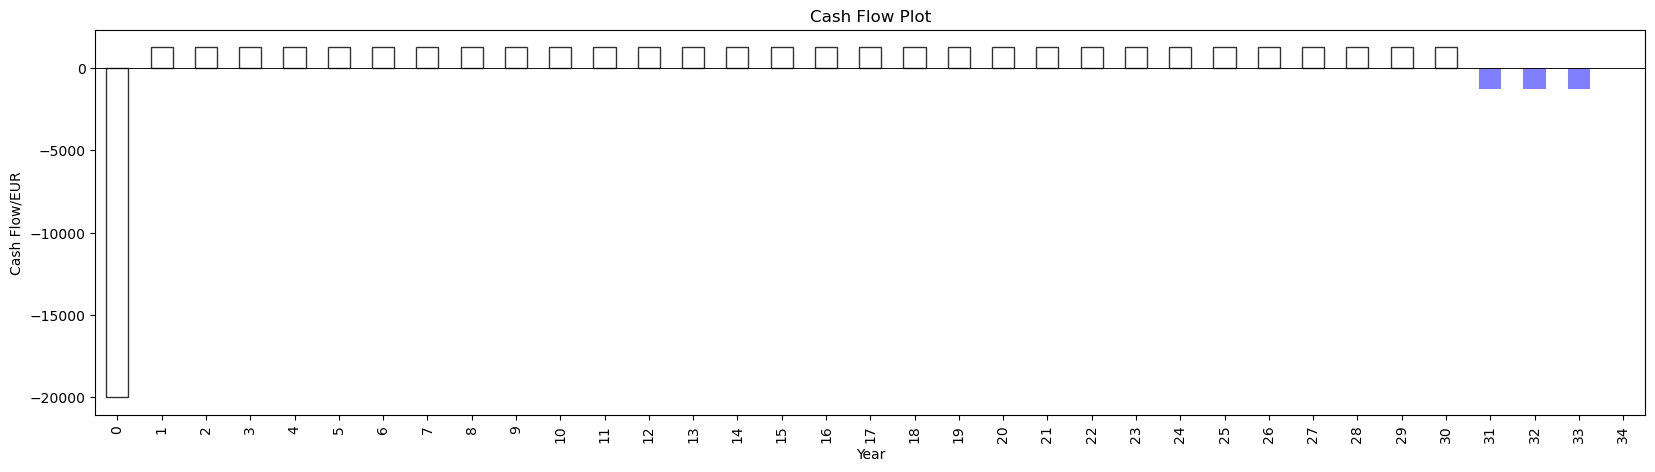

In [112]:
def credit_with_max_payment(amount, interest, max_payment, max_years = 100):
    for y in range(1, max_years):
        c = Credit(amount, y, interest)
        if c.rate() < max_payment:
            return c

# It's not possible to get a credit that pays for itself this within 30 years
CREDIT_INTEREST = 0.05
CREDIT_MAX_YEARS = 100
        
CF = CashFlow.from_investment(PERIODS, PRESENT_VALUE, ANNUAL_PAYMENT)
ccf = credit_with_max_payment(PRESENT_VALUE, CREDIT_INTEREST, ANNUAL_PAYMENT, CREDIT_MAX_YEARS).cash_flow()
tcf = CF + ccf

CF.plot(alpha=0.8, color = 'white', edgecolor = 'k')
tcf.plot(alpha = 0.5, color = 'b')

print(tcf.present_value(0.02))
print(tcf.sum())

## Deposit Equivalent

How much money would I need to deposit today, to have 15.7K in 30 years?

In [44]:
def deposit_equivalent_from_future_value(periods, future_value, interest_rate):
    return future_value / (1 + interest_rate) ** periods

Depositing an amount of 4049.1053514775126 with compound interest, give the equivalent value the PV investment after 30 years


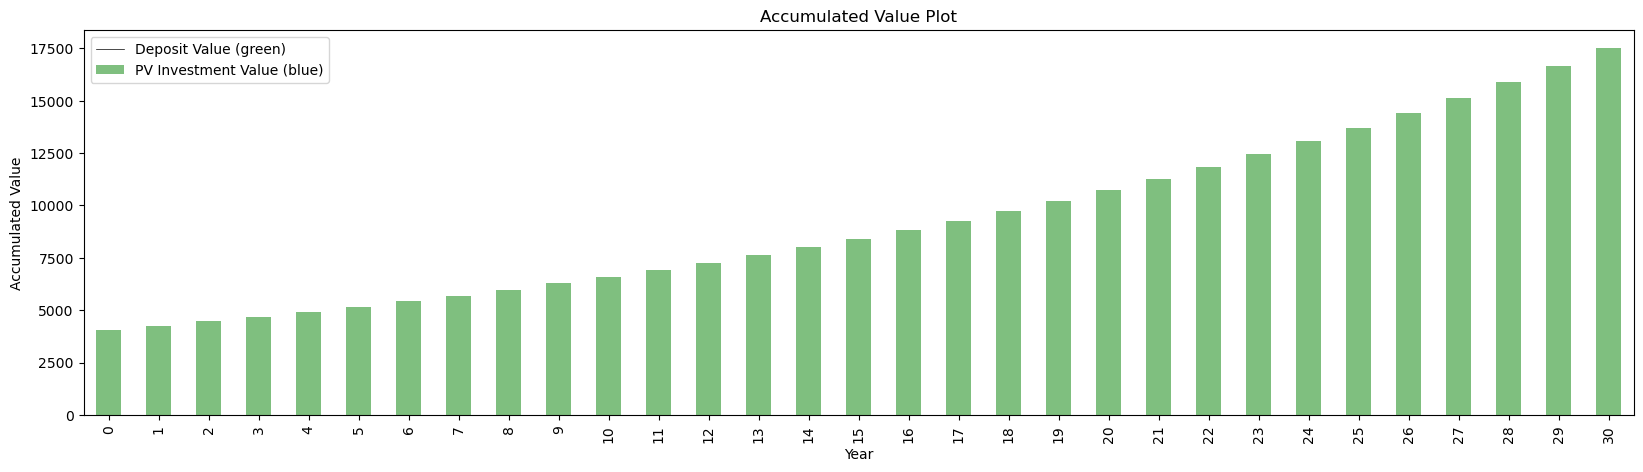

In [47]:
DEPOSIT = deposit_equivalent_from_future_value(PERIODS, N_PROFIT, 0.05)
RAV = ValueSeries.from_deposit(PERIODS, DEPOSIT).with_interest(0.05)
# AV = ValueSeries.from_cash_flow( CF )
# RAV.plot(color="green", alpha=0.5)
# AV.plot(color="blue", alpha = 1)
plt.legend(["Deposit Value (green)", "PV Investment Value (blue)"])

print(f"Depositing an amount of {DEPOSIT} with compound interest, give the equivalent value the PV investment after 30 years")

## Cash flow generated from Credit

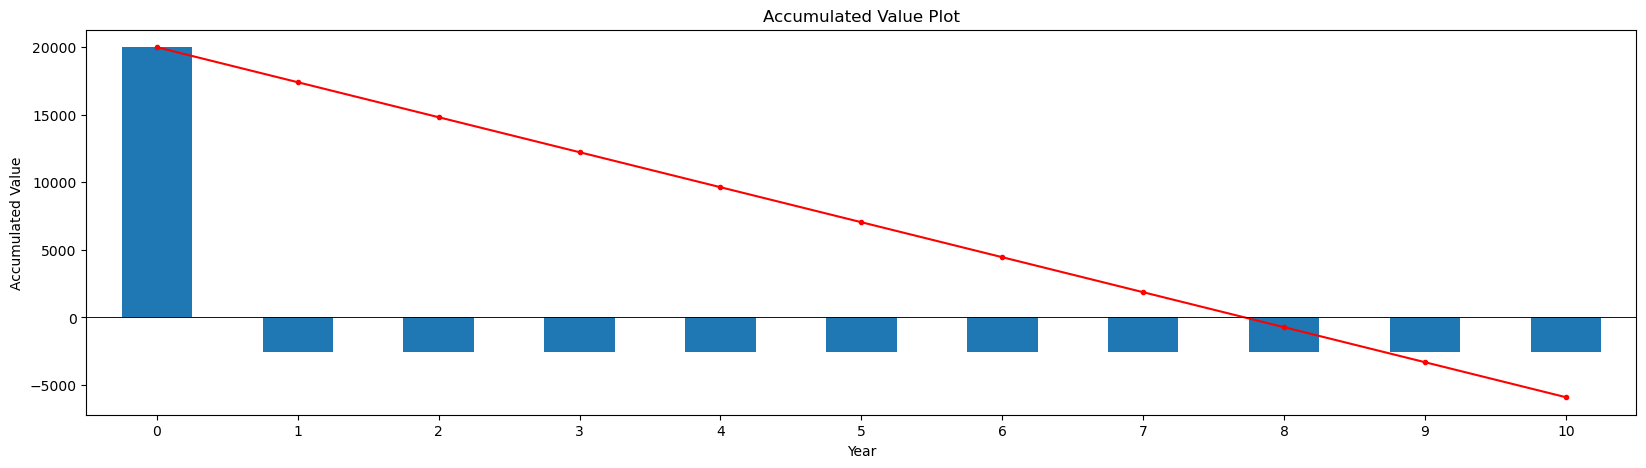

In [143]:
cf = Credit(20000, 10, 0.05).cash_flow()
cf.plot()
av = ValueSeries.from_cash_flow(cf)
av.plot(kind="line", style=".-", color="red")

## Discounted Cashflow from Credit gives Zero total value (if discounted with interest rate)

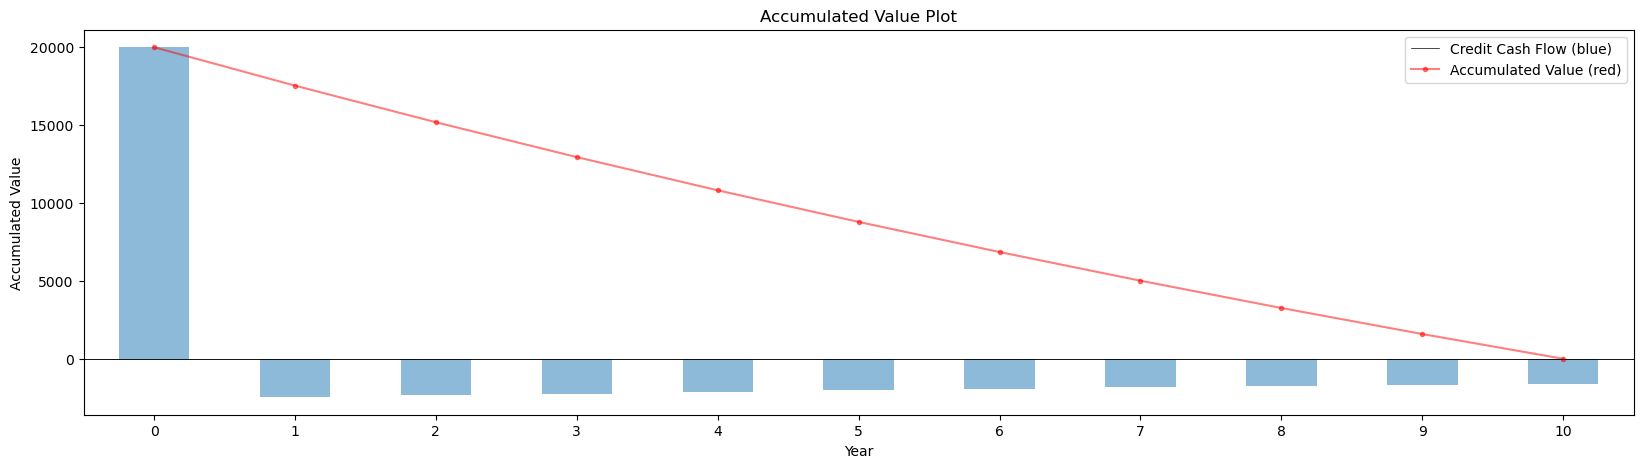

In [91]:
cf = Credit(20000, 10, 0.05).cash_flow().discount(0.05)

cf.plot(
    alpha = 0.5
)
ValueSeries.from_cash_flow(cf).plot(
    color = "red",
    alpha = 0.5,
    kind = 'line',
    style = '.-',
)
plt.legend(["Credit Cash Flow (blue)", "Accumulated Value (red)"])

## Buying stocks on Credit - Gives netural results if Stock appreciation = Credit interest

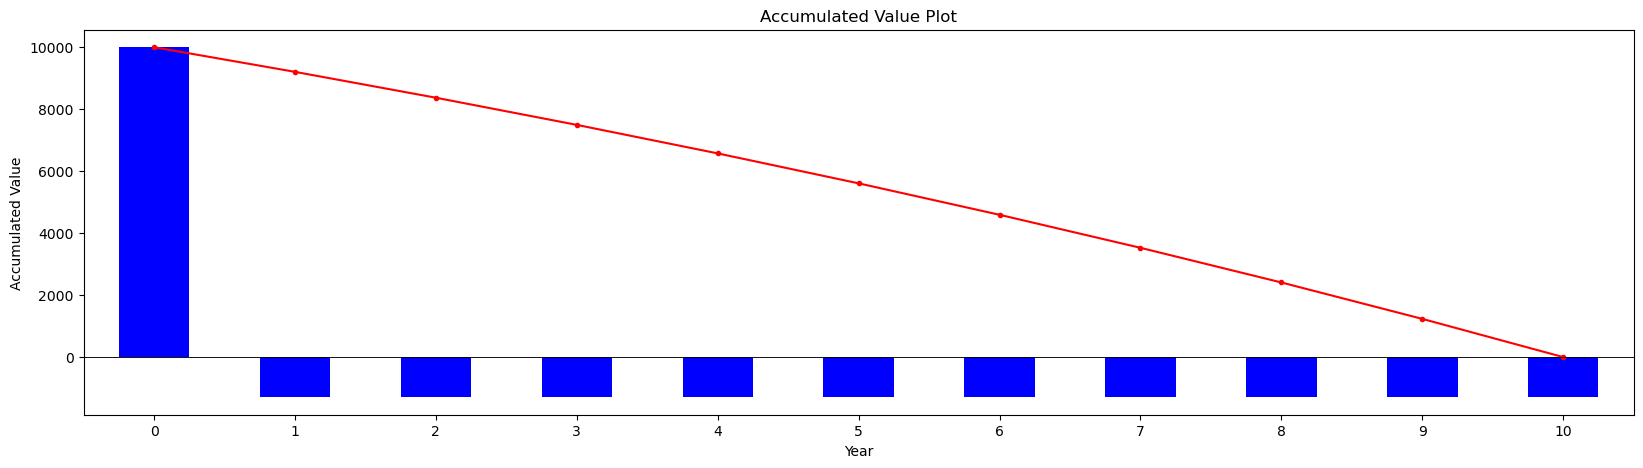

In [92]:
cf = Credit(10000, 10, 0.05).cash_flow()
av = ValueSeries.from_cash_flow(cf).with_interest(0.05)
cf.plot(color='blue')
av.plot(kind="line", style=".-", color='red')